In [1]:
# Import from standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
import random

# Import functions from file
from algorithms import *
from functions import *

# Heart disease

Data Processing

In [2]:
# Import data
df = pd.read_csv('data/heart_disease_prediction.csv')
df.head(3)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence


In [3]:
# Select features
X = df.iloc[:,[0,2,3,4,6,7,9,10,11]] #features
disease = df.iloc[:,13] #labels (heart disease = presence)
y = [1 if dis=='Presence' else -1 for dis in disease] # Create label vector
N = X.shape[0] #number of observations
X.head(10)

,Age,Chest pain type,BP,Cholesterol,EKG results,Max HR,ST depression,Slope of ST,Number of vessels fluro
0,70,4,130,322,2,109,2.4,2,3
1,67,3,115,564,2,160,1.6,2,0
2,57,2,124,261,0,141,0.3,1,0
3,64,4,128,263,0,105,0.2,2,1
4,74,2,120,269,2,121,0.2,1,1
5,65,4,120,177,0,140,0.4,1,0
6,56,3,130,256,2,142,0.6,2,1
7,59,4,110,239,2,142,1.2,2,1
8,60,4,140,293,2,170,1.2,2,2
9,63,4,150,407,2,154,4.0,2,3


In [4]:
# Standardize data
for col in X.columns:
    X[col] = (X[col] - X[col].mean())/X[col].std()

<ipython-input-4-99a3fb1218d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = (X[col] - X[col].mean())/X[col].std()


In [5]:
# Forgetting labeled data maintaining a balanced data set
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X,y, test_size=0.5, stratify=y)
X_labeled = np.array(X_labeled)
X_unlabeled = np.array(X_unlabeled)
y_labeled = np.array(y_labeled).reshape(-1,1)
y_unlabeled = np.array(y_unlabeled).reshape(-1,1)
known_variables = X_labeled.shape[0]

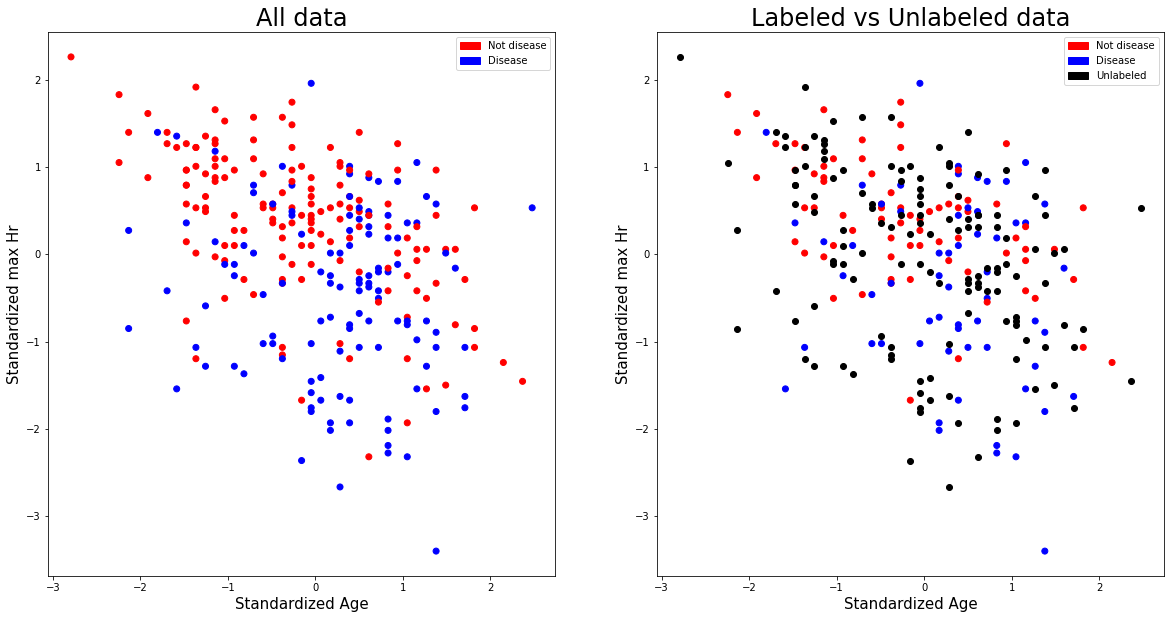

In [6]:
# Data visualization
data = {'x1 labeled': X_labeled[:,0], 'x2 labeled': X_labeled[:,5],
        'x1 unlabeled': X_unlabeled[:,0], 'x2 unlabeled': X_unlabeled[:,5],
        'y labeled': y_labeled, 'y unlabeled': y_unlabeled}
label = {'x1': 'Standardized Age', 'x2': 'Standardized max Hr', 'class': ('Not disease','Disease')}
plot_data(data, label)

In [7]:
# Computing weight matrix
W = distance_matrix(X_labeled,X_unlabeled, order = 2)
W = 1/(W**2+1) #Converting the distance matrix into a similarity (weight) matrix with values in [0,1]
W = normalize_weight_matrix(W,y_labeled,2)

Gradient Descent With Armijo

In [8]:
# Optimize with 'Gradient descent Armijo'
alpha = 1e-5
(y,y_list_GDA,time_list_GDA) = gradient_descent(W,y_labeled,np.zeros([N-known_variables,1]),armijo=True, alpha=alpha, maxIter=5000)

In [9]:
cost_list_GDA = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_GDA]

Gradient Descent

In [10]:
alpha = 1e-5
(y,y_list_GD,time_list_GD) = gradient_descent(W,y_labeled,np.zeros([N-known_variables,1]),armijo=False, alpha=alpha, maxIter=5000)

In [11]:
cost_list_GD = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_GD]

Model And Algorithm Performance

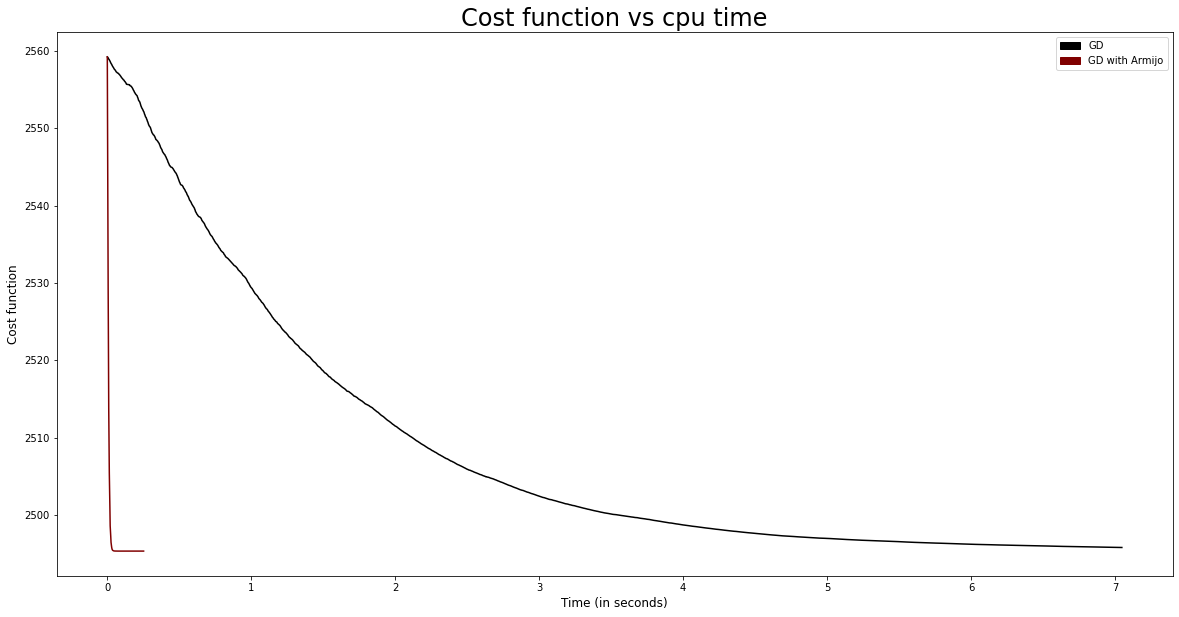

In [12]:
time_list = [time_list_GD,time_list_GDA]
loss_list = [cost_list_GD,cost_list_GDA]
name_list = ["GD","GD with Armijo"]
plot_loss_but_better(time_list, loss_list,name_list)

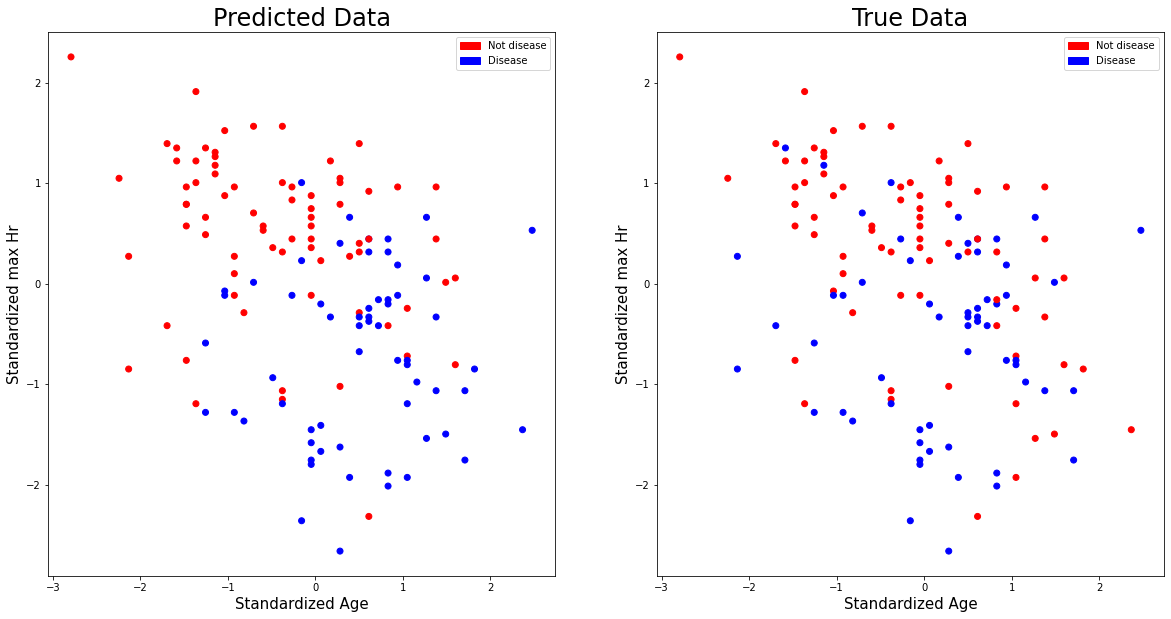

In [13]:
# Qualitative evaluation of the best model performance
best_index = np.argmin(cost_list_GDA)
y_best = y_list_GDA[best_index]
plot_performace(y_best, label, data, "Gradient Descent Classification")

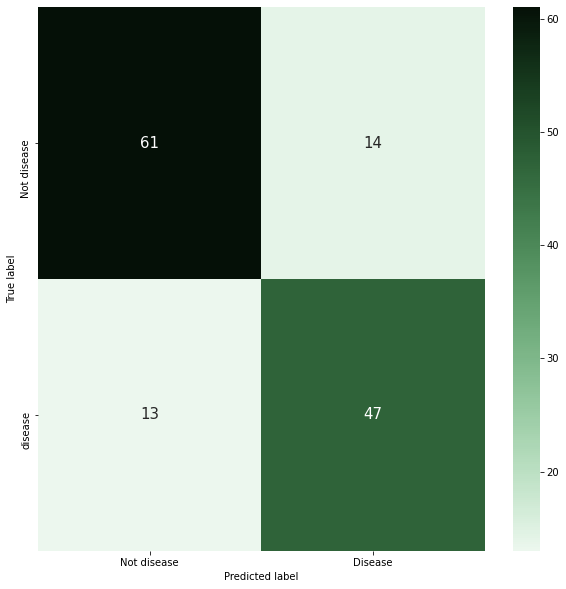

In [14]:
y_pred = np.sign(y_best)
sizeplots = (10,10)
plt.figure(figsize=sizeplots)

cm = confusion_matrix(y_unlabeled, y_pred)

sns.heatmap(cm,
            fmt= ".5g",
            annot=True,
            annot_kws={"size": 15},
            cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
            xticklabels=['Not disease', 'Disease'],
            yticklabels=['Not disease', 'disease'])
plt.xlabel("Predicted label")
_=plt.ylabel("True label")

In [15]:
avgError = np.linalg.norm(y_best-y_unlabeled, ord = 1) / (len(y_best))
classification_accuracy = 1-sum([1 for a,b in zip(y_best,y_unlabeled) if a*b<0])/len(y_best)
print("Average prediction error: ",avgError)
print("Classification_accuracy: ",classification_accuracy)

Average prediction error:  0.9104002212468106
Classification_accuracy:  0.8


In [18]:
pr,rc,f1,su = precision_recall_fscore_support(y_unlabeled,y_pred, average='binary')
    
print("""
----------------------------------------------------
-Precision: {}
-Recall: {}
-F1 score: {}
----------------------------------------------------""".format(pr,rc,f1))


----------------------------------------------------
-Precision: 0.7704918032786885
-Recall: 0.7833333333333333
-F1 score: 0.7768595041322314
----------------------------------------------------
